In [18]:
import GPy
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [19]:
import os
# os.chdir('/home/saumya/Documents/Flame_dianostics-temperature_profile_estimation_using_ML/sample code/')

os.chdir('/home/saumya/Documents/Flame_dianostics-temperature_profile_estimation_using_ML/sample code/')

In [20]:
# load training data
absorb = scio.loadmat('absorbance_TX_hitemp.mat')['absorb']
paraMat = scio.loadmat('para_TX_hitemp.mat')
Temper = paraMat['Temper']
Temper=np.reshape(Temper,-1)[:,None]
Conc_1 = paraMat['Conc_1']
Conc_1=np.reshape(Conc_1,-1)[:,None]
Conc_2 = paraMat['Conc_2']
Conc_2=np.reshape(Conc_2,-1)[:,None]

In [21]:
absorb.shape

(1000, 998)

In [22]:
Temper.shape

(1000, 1)

In [23]:
Conc_1.shape

(1000, 1)

In [24]:
X = np.arange(0, 1000)

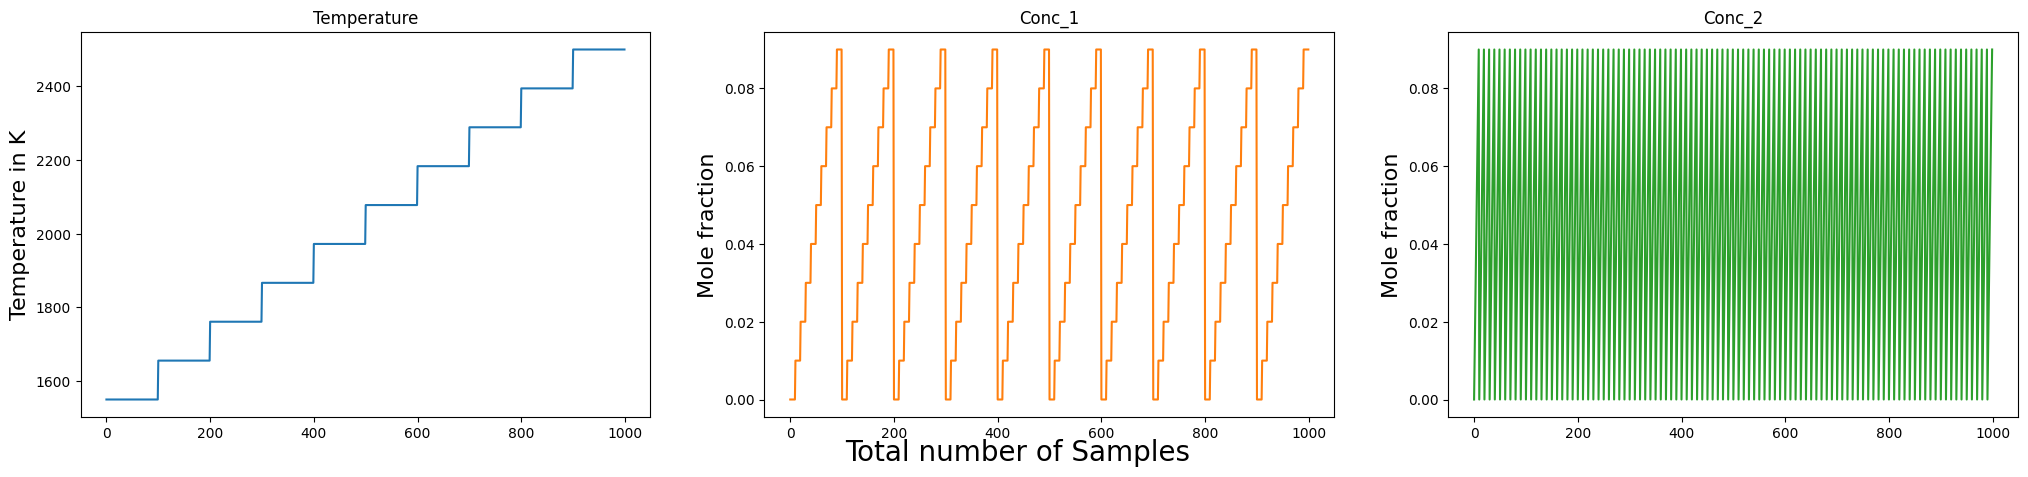

In [25]:
figure, axis = plt.subplots(1, 3) 

axis[0].plot(X, Temper)
axis[0].set_title('Temperature')
axis[0].set_ylabel('Temperature in K', fontsize=16)
axis[1].plot(X, Conc_1, 'tab:orange')
axis[1].set_title('Conc_1')
axis[1].set_ylabel('Mole fraction', fontsize=16)
axis[2].plot(X, Conc_2, 'tab:green')
axis[2].set_title('Conc_2')
axis[2].set_ylabel('Mole fraction', fontsize=16)
figure.set_figheight(5)
figure.set_figwidth(25)
figure.supxlabel('Total number of Samples', fontsize=20)
plt.savefig('Train_dat')
plt.show()

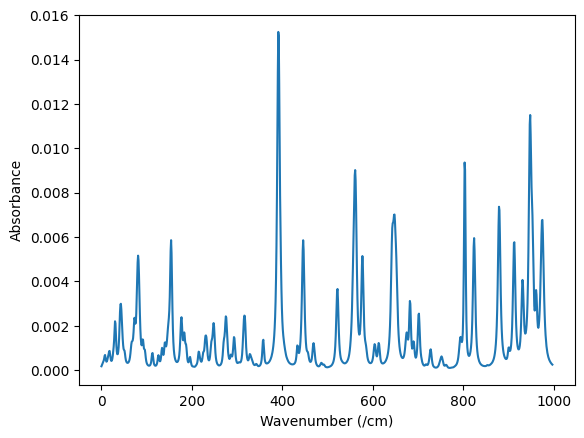

In [26]:
import matplotlib.pyplot as plt

plt.plot(absorb[331])
plt.xlabel('Wavenumber (/cm)')
plt.ylabel('Absorbance')
plt.savefig('train_img')

In [27]:
# normalization
scalerT = StandardScaler().fit(Temper)
scalerX_1 = StandardScaler().fit(Conc_1)
scalerX_2 = StandardScaler().fit(Conc_2)
Temper=scalerT.transform(Temper)
Conc_1=scalerX_1.transform(Conc_1)
Conc_2=scalerX_2.transform(Conc_2)

In [28]:
# ICM model set up
ks = GPy.kern.RBF(np.shape(absorb)[1])
icm = GPy.util.multioutput.ICM(input_dim=np.shape(absorb)[1],num_outputs=3,kernel=ks)

In [29]:
print(icm)
print('W matrix\n',icm.B.W)
print('\nkappa vector\n',icm.B.kappa)
print('\nB matrix\n',icm.B.B)

  ICM.             |   value  |  constraints  |  priors
  rbf.variance     |     1.0  |      +ve      |        
  rbf.lengthscale  |     1.0  |      +ve      |        
  B.W              |  (3, 1)  |               |        
  B.kappa          |    (3,)  |      +ve      |        
W matrix
   index  |      ICM.B.W  |  constraints  |  priors
  [0 0]  |  -0.43787424  |               |        
  [1 0]  |   0.20752868  |               |        
  [2 0]  |  -0.66506672  |               |        

kappa vector
   index  |  ICM.B.kappa  |  constraints  |  priors
  [0]    |   0.50000000  |      +ve      |        
  [1]    |   0.50000000  |      +ve      |        
  [2]    |   0.50000000  |      +ve      |        

B matrix
 [[ 0.69173385 -0.09087146  0.29121559]
 [-0.09087146  0.54306815 -0.13802042]
 [ 0.29121559 -0.13802042  0.94231375]]


In [30]:
np.array([Temper,Conc_1,Conc_2]).shape

(3, 1000, 1)

In [31]:
#This functions generate data corresponding to two outputs
f_output1 = lambda x: 4. * np.cos(x/5.) - .4*x - 35. + np.random.rand(x.size)[:,None] * 2.
f_output2 = lambda x: 6. * np.cos(x/5.) + .2*x + 35. + np.random.rand(x.size)[:,None] * 8.


#{X,Y} training set for each output
X1 = np.random.rand(100)[:,None]; X1=X1*75
X2 = np.random.rand(100)[:,None]; X2=X2*70 + 30
Y1 = f_output1(X1)
Y2 = f_output2(X2)
#{X,Y} test set for each output
Xt1 = np.random.rand(100)[:,None]*100
Xt2 = np.random.rand(100)[:,None]*100
Yt1 = f_output1(Xt1)
Yt2 = f_output2(Xt2)

In [32]:
m = GPy.models.GPCoregionalizedRegression([absorb,absorb,absorb],[Temper,Conc_1,Conc_2],kernel=icm)
m['.*rbf.var'].constrain_fixed(1.)
# constrain if converge to reasonless extrema
# m['mixed_noise.Gaussian_noise_0.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_1.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_2.variance'].constrain_bounded(0,1e-5)
print(m)


Name : gp
Objective : 3702.9294033035603
Number of Parameters : 11
Number of Optimization Parameters : 10
Updates : True
Parameters:
  gp.                                    |   value  |  constraints  |  priors
  ICM.rbf.variance                       |     1.0  |   +ve fixed   |        
  ICM.rbf.lengthscale                    |     1.0  |      +ve      |        
  ICM.B.W                                |  (3, 1)  |               |        
  ICM.B.kappa                            |    (3,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |     1.0  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |     1.0  |      +ve      |        
  mixed_noise.Gaussian_noise_2.variance  |     1.0  |      +ve      |        


In [33]:
print('W matrix\n',icm.B.W)
print('\nkappa vector\n',icm.B.kappa)

W matrix
   index  |   gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  -0.43787424  |               |        
  [1 0]  |   0.20752868  |               |        
  [2 0]  |  -0.66506672  |               |        

kappa vector
   index  |  gp.ICM.B.kappa  |  constraints  |  priors
  [0]    |      0.50000000  |      +ve      |        
  [1]    |      0.50000000  |      +ve      |        
  [2]    |      0.50000000  |      +ve      |        


In [34]:
m.optimize()

In [35]:
print(m)
print('W matrix\n',icm.B.W)
print('\nkappa vector\n',icm.B.kappa)
print('\nB matrix\n',icm.B.B)


Name : gp
Objective : -10875.503470164387
Number of Parameters : 11
Number of Optimization Parameters : 10
Updates : True
Parameters:
  gp.                                    |                   value  |  constraints  |  priors
  ICM.rbf.variance                       |                     1.0  |   +ve fixed   |        
  ICM.rbf.lengthscale                    |     0.17129031798948768  |      +ve      |        
  ICM.B.W                                |                  (3, 1)  |               |        
  ICM.B.kappa                            |                    (3,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |     0.01853737716540788  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |  3.092630939743019e-169  |      +ve      |        
  mixed_noise.Gaussian_noise_2.variance  |  2.091980519229678e-140  |      +ve      |        
W matrix
   index  |   gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  -147.51656851  |               |        

In [36]:
# load test data and normalization
absorb_test = scio.loadmat('absorbance_TXtest_hitemp_noise.mat')['absorb']
paraMat_test = scio.loadmat('para_TXtest_hitemp.mat')
Temper_test = paraMat_test['Temper']
Temper_test=np.reshape(Temper_test,-1)[:,None]
Conc_1_test = paraMat_test['Conc_1']
Conc_1_test=np.reshape(Conc_1_test,-1)[:,None]
Conc_2_test = paraMat_test['Conc_2']
Conc_2_test=np.reshape(Conc_2_test,-1)[:,None]

In [37]:
absorb_test.shape

(50, 998)

In [38]:
Temper_test.shape

(50, 1)

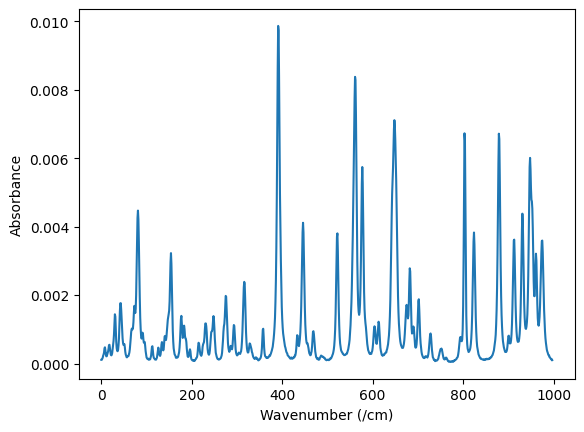

In [39]:
plt.plot(absorb_test[10])
plt.xlabel('Wavenumber (/cm)')
plt.ylabel('Absorbance')
plt.savefig('test_img')

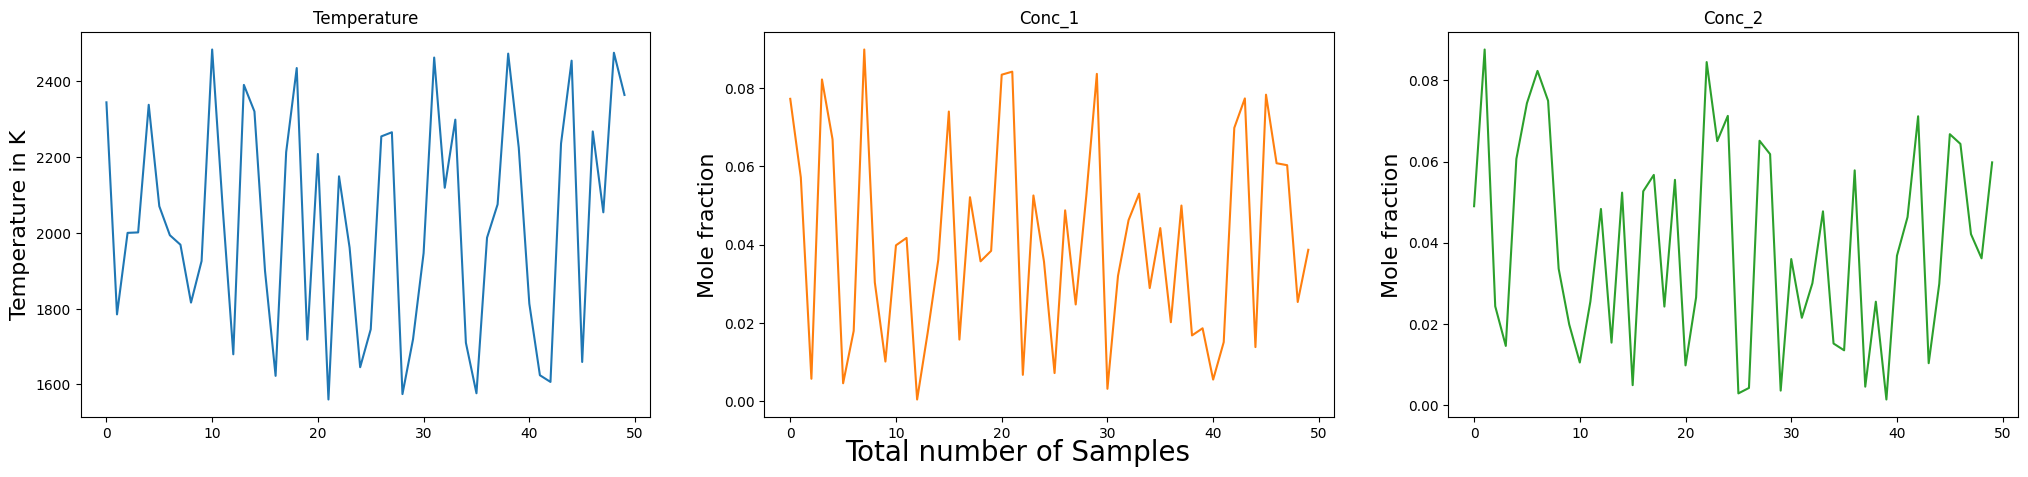

In [40]:
figure, axis = plt.subplots(1, 3) 

axis[0].plot(Temper_test)
axis[0].set_title('Temperature')
axis[0].set_ylabel('Temperature in K', fontsize=16)
axis[1].plot(Conc_1_test, 'tab:orange')
axis[1].set_title('Conc_1')
axis[1].set_ylabel('Mole fraction', fontsize=16)
axis[2].plot(Conc_2_test, 'tab:green')
axis[2].set_title('Conc_2')
axis[2].set_ylabel('Mole fraction', fontsize=16)
figure.set_figheight(5)
figure.set_figwidth(25)
figure.supxlabel('Total number of Samples', fontsize=20)
plt.savefig('test_dat')
plt.show()

In [41]:
# prediction of Tue
newX = absorb_test
newX = np.concatenate((newX,np.zeros((np.shape(absorb_test)[0],1))),1)
noise_dict = {'output_index':newX[:,-1].astype(int)}
ys,var=m.predict(newX,Y_metadata=noise_dict)

Temper_test_=scalerT.inverse_transform(ys)

In [42]:
# prediction of X1
newX = absorb_test
newX = np.concatenate((newX,np.ones((np.shape(absorb_test)[0],1))),1)
noise_dict = {'output_index':newX[:,-1].astype(int)}
ys,var=m.predict(newX,Y_metadata=noise_dict)

Conc_1_test_=scalerX_1.inverse_transform(ys)

In [43]:
# prediction of X2
newX = absorb_test
newX = np.concatenate((newX,2*np.ones((np.shape(absorb_test)[0],1))),1)
noise_dict = {'output_index':newX[:,-1].astype(int)}
ys,var=m.predict(newX,Y_metadata=noise_dict)

Conc_2_test_=scalerX_2.inverse_transform(ys)

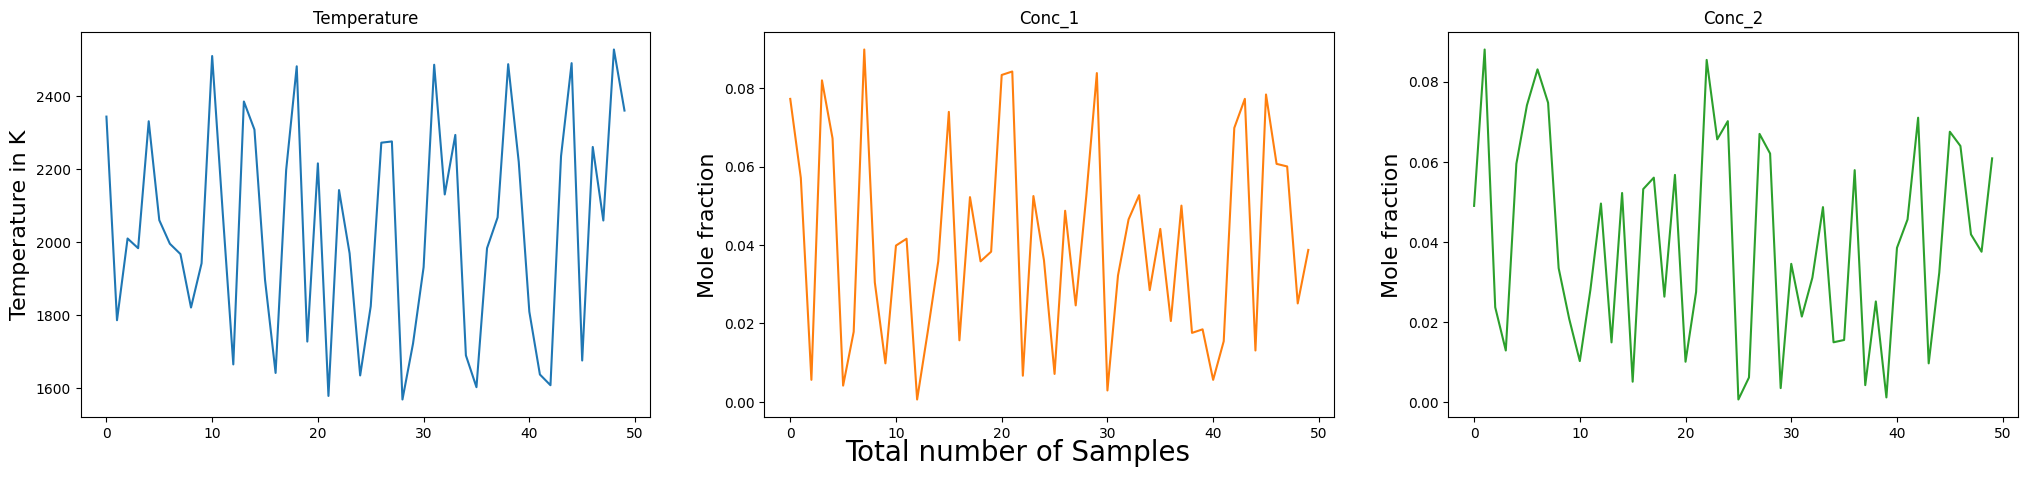

In [44]:
figure, axis = plt.subplots(1, 3) 

axis[0].plot(Temper_test_)
axis[0].set_title('Temperature')
axis[0].set_ylabel('Temperature in K', fontsize=16)
axis[1].plot(Conc_1_test_, 'tab:orange')
axis[1].set_title('Conc_1')
axis[1].set_ylabel('Mole fraction', fontsize=16)
axis[2].plot(Conc_2_test_, 'tab:green')
axis[2].set_title('Conc_2')
axis[2].set_ylabel('Mole fraction', fontsize=16)
figure.set_figheight(5)
figure.set_figwidth(25)
figure.supxlabel('Total number of Samples', fontsize=20)
plt.savefig('test_res')
plt.show()

In [45]:
from sklearn import metrics

In [46]:
conc_1 = metrics.mean_squared_log_error(np.array(Conc_1_test), np.array(Conc_1_test_))
conc_1

5.8324568865566335e-08

In [47]:
conc_2 = metrics.mean_squared_log_error(np.array(Conc_2_test), np.array(Conc_2_test))
conc_2

0.0

In [48]:
temp = metrics.mean_squared_log_error(Temper_test_, Temper_test)
temp

9.378235815472874e-05

In [49]:
print(f'The mean squared log error for the Test and Predicted class is as follows, Temp: {temp}, Concentration 1: {conc_1} and Concentration 2: {conc_2}')

The mean squared log error for the Test and Predicted class is as follows, Temp: 9.378235815472874e-05, Concentration 1: 5.8324568865566335e-08 and Concentration 2: 0.0
